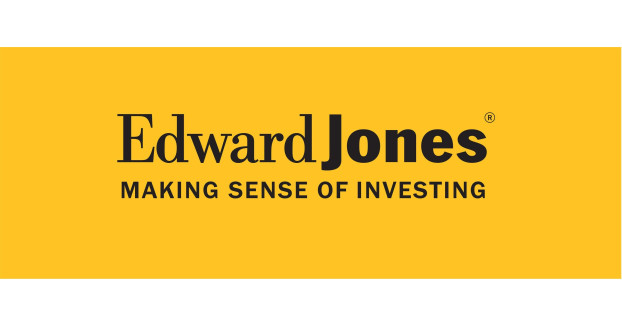

# Edward Jones Capstone Project
 Edward Jones is looking to set fair service level agreements with its life insurance carrier partners. Historically, the carriers average two to three months to complete an application. We looked to build a model to either confirm this time period or make a claim for adjustment.

This Jupyter notebook is used to build a model to predict how many days it takes to submit and place a life insurance policy using the last 12 months of data on life insurance applications. This model will tell us which elements have an affect on the days to submit and will assist us in establishing service level agreements (SLA) with all the carriers.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import cross_validate
import time
from sklearn.model_selection import train_test_split
import pandas.testing
import io
import requests

%matplotlib notebook

In [2]:
#Need to install xgboost which we use as a model in our code

!pip install xgboost

In [3]:
#Read in the data

df = pd.read_csv('ASU_Team10Project_InsuranceDataset.csv', low_memory=False)

In [4]:
#We need to shuffle our data as how it is currently set the target variable
#is in an order. This may cause some of our features to be correlated that
#shouldn't be. Policy number was one that was very heavily correlated due
#to the sequence of the days submitted to final

from sklearn.utils import shuffle
df = shuffle(df, random_state=101)
df.reset_index(drop=True, inplace=True)
df

,Carrier,Policy #,U/W Type,Plan Type,Plan Type Group,Term Duration (Yrs),Benefit,Stage,Submitted Date,Days in Submitted,...,Processing Type,Insured Age,Risk Class,Product,# of APS?,1035?,Interview,Exam,Requirement Group 1,Requirement Group 2
0,Company A,13217,Full Underwriting,UL,Hybrid,NaN,50822.0,Final - Inforce,8/8/2019,1,...,NaN,52.0,Preferred Non-Smoker,Company A Hybrid,0.0,No,Yes,No,Neither,Interview
1,Company A,68291,Full Underwriting,Term,Term,20,250000.0,Final - Not Active,4/23/2020,0,...,NaN,40.0,Standard Non-Smoker,Company A Term 2,NaN,NaN,NaN,NaN,NaN,NaN
2,Company B,16883,Full Underwriting,Term,Term,20,250000.0,Final - Inforce,11/11/2019,1,...,New Application,42.0,Preferred Plus,Company B Term,0.0,No,Yes,Yes,Neither,Interview & Exam
3,Company B,75879,Full Underwriting,Term,Term,20,500000.0,Underwriting,8/26/2020,0,...,New Application,47.0,Preferred Non-Smoker,Company B Term,NaN,NaN,NaN,NaN,NaN,NaN
4,Company C,40517,Full Underwriting,VUL,Perm,NaN,250000.0,Final - Inforce,1/17/2020,3,...,NaN,62.0,Preferred Plus,Company C VUL 1,0.0,Yes,Yes,Yes,1035,Interview & Exam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87667,Company E,5696,Express Underwriting,Term,Term,30,500000.0,Final - Inforce,9/23/2019,7,...,NaN,39.0,Preferred Non-Smoker,Company E Term,0.0,No,Yes,No,Neither,Interview
87668,Company E,73543,Express Underwriting,Term,Term,10,400000.0,Issued,8/10/2020,11,...,NaN,37.0,Preferred Non-Smoker,Company E Term,NaN,NaN,NaN,NaN,NaN,NaN
87669,Company E,83282,Full Underwriting,VUL,Perm,NaN,1000000.0,Underwriting,8/27/2020,4,...,NaN,48.0,NaN,Company E VUL 2,NaN,NaN,NaN,NaN,NaN,NaN
87670,Company B,83468,Full Underwriting,Term,Term,20,1000000.0,Underwriting,7/27/2020,0,...,New Application,45.0,Standard Non-Smoker,Company B Term,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Remove all the spaces within the columns of df as there are some issues
#when calling columns with spaces

col = list(df.columns)

for i in range(len(col)):
    oldstr = col[i]
    regex_2 = re.compile(r' ')
    newstr = regex_2.sub('', oldstr)
    col[i] = newstr
    
df.columns = col

In [6]:
#We have multiple dates in our dataset, but they are currently labeled as objects. 
#This code loops through all the date columns and converts them to datetime datatypes.
#This is needed later when we join new data on dates.

change_col = []

for i in df.columns:
    oldstr = i
    regex = re.compile(r'[a-zA-z]+-*[a-zA-z]+Date')
    newstr = regex.findall(oldstr)
    if not newstr: 
        continue
    else:
        change_col.append(newstr)
        
for i in range(len(change_col)):
    df[change_col[i][0]] =pd.to_datetime(df[change_col[i][0]])

In [7]:
#set what target variable we would like to predict. We can choose between all the different stages
#in the lifecycle of the application which include:

#'DaysSubmittedtoFinal', 'DaysinSubmitted','DaysinUnderwriting', 'DaysinApproval', and 'DaysinIssued'


target = 'DaysSubmittedtoFinal'

# Functions used to prep data

In [8]:
#Need a way to deal with columns that are categorical for use in a predictive
#model. We are going to be building a model that predicts
#Days Submitted to Final only for records that are at the stage Final-Inforce

def dum_df(df):
    df = df[df['Stage'] == 'Final - Inforce']
    #df = df[df['SubmittedDate'] >= '4/1/2020'] #if we want to filter by pre/post covid we will include this line
    df = pd.get_dummies(df, columns=['Carrier', 'U/WType', 'PlanType', 'PlanTypeGroup', 'RiskClass', 'Interview',
                       'Exam', '1035?'], drop_first=True)
    return df

def df_timeadj(df):
    #this creates dummy variables for the month of the claim in case we want to look into trends by month
    #example: if we have a lot less claims in Feb than other months we expect shorter turnaround
    #We did not use this function outside of exploratory analysis as if our model knows what month an application
    #went to inforce it essentially has a rough idea already of how long it will take and can predict with high
    #accuracy
    import datetime as dt
    df['InforceMonth'] = pd.DatetimeIndex(df['InforceDate']).month
    df = pd.get_dummies(df, columns=['InforceMonth'], drop_first=True)
    return df

def APS_var(df):
#create categorical variable that mentions if an APS was called. 1 for yes, 0 for no
# this is different than the # of APS. We ended up not using this due to it being multicollinear with # of APS
    df['APS_Yes'] = 0

    for i in df.index:
        if df['#ofAPS?'].loc[i] > 0:
            df['APS_Yes'].loc[i] = 1
        else:
            df['APS_Yes'].loc[i] = 0
    return df
          

def col_clean(df):
#Remove all the spaces within the columns of df as there are some issues to avoid any potential issues
#when calling columns with spaces

    col = list(df.columns)

    for i in range(len(col)):
        oldstr = col[i]
        regex_2 = re.compile(r' ')
        newstr = regex_2.sub('', oldstr)
        col[i] = newstr
    
    df.columns = col
    return df

def combine_UW(df):
    #Combining reduced and full underwriting into one feature as 
    #Edward Jones reports both as one
    df['U/WCombined'] = df['U/WType_FullUnderwriting'] + df['U/WType_ReducedUnderwriting']
    df.drop(['U/WType_FullUnderwriting', 'U/WType_ReducedUnderwriting'], axis=1, inplace=True)
    return df

def df_clean(df, col):
    #create a dataframe of absolute value of correlations
    tx = pd.DataFrame(abs(df.corrwith(df[col])))
    new_lst = list()
    threshold = 0
    #for loop that iterates through each absolute value of correlation and
    #saves it to new_list if above certain threshold defined above
    for i in range(len(tx)-1):
        if tx.loc[tx.index[i+1]][0] > threshold:
            new_lst.append(tx.index[i+1])
    
    new_df = df[new_lst]
    #if the features in drop_val exist in new_df we drop them. We won't
    #have these values when we gain new applications
    target_feats = ['DaysSubmittedtoFinal', 'DaysinSubmitted','DaysinUnderwriting', 'DaysinApproval', 'DaysinIssued']
    target_feats.remove(target)
    drop_val = ['Carrier_CompanyC', 'Carrier_CompanyB', 
               'Carrier_CompanyD', 'Carrier_CompanyE', 'Carrier_CompanyF', 
               'Stage', 'ProcessingType', 'Policy#', 'PlanTypeGroup_Term']
    for i in range(len(target_feats)):
        drop_val.append(target_feats[i])
    
    new_col = []
    for i in new_df.columns:
        if i not in drop_val:
            new_col.append(i)
        
    new_df = new_df[new_col]
    return new_df

def data_clean_funcs(df):
    #this function iterates through all steps to make it a quick process to format our data
    df = dum_df(df)
    df.reset_index(drop=True, inplace=True)
#     df = df_timeadj(df) removed this function due to unfair predictability
    df = col_clean(df)
    df = combine_UW(df)
#    df = APS_var(df) removed this function due to multicollinearity with #ofAPS
    return df

In [9]:
#Takes our dataframe and runs all the preprocessing steps to return a cleaned dataframe
df = df.copy()
df = data_clean_funcs(df)
df

,Policy#,TermDuration(Yrs),Benefit,Stage,SubmittedDate,DaysinSubmitted,UnderwritingDate,DaysinUnderwriting,ApprovalDate,DaysinApproval,...,RiskClass_PreferredPlus,RiskClass_PreferredSmoker,RiskClass_Rated/SubstandardRisk,RiskClass_StandardNon-Smoker,RiskClass_StandardPlus,RiskClass_StandardSmoker,Interview_Yes,Exam_Yes,1035?_Yes,U/WCombined
0,13217,NaN,50822.0,Final - Inforce,2019-08-08,1,2019-08-09,33,2019-09-11,1,...,0,0,0,0,0,0,1,0,0,1
1,16883,20,250000.0,Final - Inforce,2019-11-11,1,2019-11-12,29,2019-12-11,2,...,1,0,0,0,0,0,1,1,0,1
2,40517,NaN,250000.0,Final - Inforce,2020-01-17,3,2020-01-20,85,2020-04-14,2,...,1,0,0,0,0,0,1,1,1,1
3,14066,NaN,250000.0,Final - Inforce,2020-07-06,3,2020-07-09,22,2020-07-31,12,...,0,0,0,0,0,0,0,0,0,1
4,48049,NaN,100000.0,Final - Inforce,2019-04-25,1,2019-04-26,145,2019-09-18,0,...,0,0,0,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50951,17358,NaN,102767.0,Final - Inforce,2019-10-23,6,2019-10-29,21,2019-11-19,13,...,0,0,0,0,0,0,1,0,0,1
50952,20464,25,500000.0,Final - Inforce,2019-12-19,5,2019-12-24,42,NaT,0,...,0,0,0,0,0,0,0,1,0,1
50953,49752,20,300000.0,Final - Inforce,2019-12-28,2,2019-12-30,163,2020-06-10,1,...,0,0,0,1,0,0,1,1,0,1
50954,5696,30,500000.0,Final - Inforce,2019-09-23,7,2019-09-30,11,2019-10-11,4,...,0,0,0,0,0,0,1,0,0,0


# Exploratory Analysis

Before attempting to build a predictive model that predicts the time it takes to go from underwriting to inforced, we need to explore our data to understand the nuances. By conducting exploratory analysis, we can understand the variation within the data, where we need to handle missing values, etc.

In [10]:
#Looking into the seasonality or how COVID may have impacted the length
#of time to submission

#This loop prints out the average days submitted to final and amount of 
#business closed by month starting Sept 2019 - Aug 2020. We chose to ignore 2018.

dates = [9,10,11,12,1,2,3,4,5,6,7,8]
months = ['Sept 2019', 'Oct 2019', 'Nov 2019', 'Dec 2019', 
          'Jan 2020', 'Feb 2020', 'Mar 2020', 'Apr 2020', 
          'May 2020', 'Jun 2020', 'July 2020', 'Aug 2020']

for i in range(len(dates)):
    print(months[i])
    print('Average', target, ':', round(df[df['SubmittedDate'].dt.month == dates[i]][target].mean(),2))
    print('Placed Business by Month:', df[df['SubmittedDate'].dt.month == dates[i]][target].count())
    print()

Sept 2019
Average DaysSubmittedtoFinal : 75.27
Placed Business by Month: 4290

Oct 2019
Average DaysSubmittedtoFinal : 73.25
Placed Business by Month: 5440

Nov 2019
Average DaysSubmittedtoFinal : 77.96
Placed Business by Month: 4243

Dec 2019
Average DaysSubmittedtoFinal : 74.61
Placed Business by Month: 3480

Jan 2020
Average DaysSubmittedtoFinal : 69.17
Placed Business by Month: 4571

Feb 2020
Average DaysSubmittedtoFinal : 71.43
Placed Business by Month: 4340

Mar 2020
Average DaysSubmittedtoFinal : 70.86
Placed Business by Month: 4065

Apr 2020
Average DaysSubmittedtoFinal : 72.79
Placed Business by Month: 3593

May 2020
Average DaysSubmittedtoFinal : 75.18
Placed Business by Month: 3900

Jun 2020
Average DaysSubmittedtoFinal : 72.64
Placed Business by Month: 3905

July 2020
Average DaysSubmittedtoFinal : 76.33
Placed Business by Month: 4296

Aug 2020
Average DaysSubmittedtoFinal : 76.08
Placed Business by Month: 4833



One task of our project was to look to see if there was any variations in the process time due to COVID. COVID was announced a global pandemic on March 11th and we noticed a decrease in business in April, May, and June. The process time seems to be unchanged so therefore seasonality may not explain much of the variation in our process time. COVID does seem to effect the number of cases so maybe we can add COVID cases as an extra feature in our dataset.

Next thing worth looking into is the differences between each Carrier company. Each carrier has different processes and nuances within how their application process works. This could help explain why there is so much variation. 

In [11]:
#Can run this code to generate the average number of days submitted to final by company for dates
#Can swap out carrier name and date. For carrier A, we need to set all carriers equal to 0.
#I already have run this code and printed the results in the markdown below. This is here for reference.
#Can also adjust the date to greater than 3/1/2020 to view how the averages change post COVID.

#df[(df['Carrier_CompanyB'] == 1) & (df['InforceDate'] < '3/1/2020')]['DaysSubmittedtoFinal'].mean()
#df[(df['Carrier_CompanyC'] == 1) & (df['InforceDate'] < '3/1/2020')]['DaysSubmittedtoFinal'].mean()
#df[(df['Carrier_CompanyD'] == 1) & (df['InforceDate'] < '3/1/2020')]['DaysSubmittedtoFinal'].mean()
#df[(df['Carrier_CompanyE'] == 1) & (df['InforceDate'] < '3/1/2020')]['DaysSubmittedtoFinal'].mean()
#df[(df['Carrier_CompanyF'] == 1) & (df['InforceDate'] < '3/1/2020')]['DaysSubmittedtoFinal'].mean()
#df[(df['Carrier_CompanyB'] == 0) & (df['InforceDate'] < '3/1/2020') & (df['Carrier_CompanyC'] == 0) & (df['Carrier_CompanyD'] == 0) & (df['Carrier_CompanyE'] == 0) & (df['Carrier_CompanyF'] == 0)]['DaysSubmittedtoFinal'].mean()



In [12]:
#This code returns the standard deviation of days submitted to final by Carrier. As stated in the previous line of code
#I added all the results to the markdown below. This is here as a reference.

# df[df['Carrier_CompanyB'] == 1]['DaysSubmittedtoFinal'].std()
# df[df['Carrier_CompanyC'] == 1]['DaysSubmittedtoFinal'].std()
# df[df['Carrier_CompanyD'] == 1]['DaysSubmittedtoFinal'].std()
# df[df['Carrier_CompanyE'] == 1]['DaysSubmittedtoFinal'].std()
# df[df['Carrier_CompanyF'] == 1]['DaysSubmittedtoFinal'].std()
# df[(df['Carrier_CompanyB'] == 0) & (df['Carrier_CompanyC'] == 0) & (df['Carrier_CompanyD'] == 0) & (df['Carrier_CompanyE'] == 0) & (df['Carrier_CompanyF'] == 0)]['DaysSubmittedtoFinal'].std()

### Exploratory Statistics for Days Submitted to Final by Carrier Companies

Average Days Submitted to Final by Company after March 1st:
- Company A: 57.33 days
- Company B: 75.91 days
- Company C: 102.28 days
- Company D: 75.70 days
- Company E: 73.06 days
- Company F: 75.47 days

Average Days Submitted to Final by Company before March 1st:
- Company A: 67.57 days
- Company B: 75.93 days
- Company C: 99.69 days
- Company D: 72.13 days
- Company E: 78.14 days

- Company F: 73.87 days

Standard Deviation of Days Submitted to Final by Company
- Company A: 41.60 days
- Company B: 45.84 days
- Company C: 49.69 days
- Company D: 48.81 days
- Company E: 44.90 days
- Company F: 41.06 days

We notice here that Company A seems to always be quicker with their process time than the rest of the carriers and that Company C is always slower. We attempted to run a model to build an SLA on all companies except these two, but we did not see an improvement in performance. We can attest this to the standard deviation. The standard deviation of these companies are relatively similar to the rest and therefore removing them does not gain us much predictability.

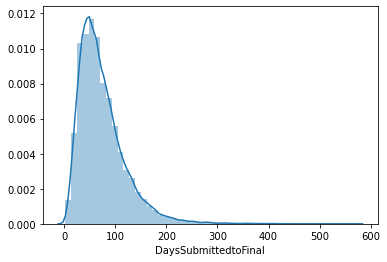

In [13]:
#View the distribution of our target variable
sns.distplot(df[target])

In [14]:
#Looks like we may have some outliers by looking at the max value here. Will need to evaluate futher

df[target].describe()

count    50956.000000
mean        73.790427
std         45.876000
min          2.000000
25%         42.000000
50%         64.000000
75%         94.000000
max        570.000000
Name: DaysSubmittedtoFinal, dtype: float64

In [15]:
#returns values above 3 standard deviations from our mean. These would be considered outliers and we would want to 
#remove these from our data to improve our model's performance. We will address this later when we 
#split our data into subsets by Carrier

df[df[target] > (df[target].mean() + (3*df[target].std()))][target]

64       233.0
73       270.0
179      260.0
298      271.0
331      229.0
         ...  
50584    235.0
50619    251.0
50638    276.0
50765    227.0
50931    237.0
Name: DaysSubmittedtoFinal, Length: 761, dtype: float64

In [16]:
#Our client advised to drop records with a null issued date when looking at target variable of days in issued
#Our client advised to drop records with a null issued date when looking at target variable of days in approval

if target == 'DaysinIssued':
    df['IssuedDate'].dropna(axis=0, inplace=True)
elif target == 'DaysinApproval':
    df['ApprovalDate'].dropna(axis=0, inplace=True)

# More Data

We wanted to see if we could find any more data that may be able to explain the variation in our dataset. Since Edward Jones didn't have any more features we could add to our dataset, we decided to explore the impact of COVID cases on the amount of time to submit a claim. We loaded in data we found from the European CDC for extra features in hopes of building a more predictive SLA. This gives us case information in the entire US. The thought process was the more cases, the slower the process time due to employees working from home or employees being fuloughed/laid off.

In [17]:
#using the requests library we will grab our data for covid. This will allow us to work with the most recent
#version of the data. 

url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
r = requests.get(url)
if r.ok:
    data = r.content.decode('utf8')
    covid = pd.read_csv(io.StringIO(data))

covid = covid[covid['location'] == 'United States']
covid['date'] = pd.to_datetime(covid['date'])

df = df.merge(covid, left_on='SubmittedDate', right_on='date', how='inner')

df.reset_index(drop=True, inplace=True)
df

,Policy#,TermDuration(Yrs),Benefit,Stage,SubmittedDate,DaysinSubmitted,UnderwritingDate,DaysinUnderwriting,ApprovalDate,DaysinApproval,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,40517,NaN,250000.0,Final - Inforce,2020-01-17,3,2020-01-20,85,2020-04-14,2,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
1,16773,10,400000.0,Final - Inforce,2020-01-17,0,2020-01-17,35,NaT,0,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
2,41783,15,250000.0,Final - Inforce,2020-01-17,0,2020-01-17,68,2020-03-25,8,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
3,24400,20,300000.0,Final - Inforce,2020-01-17,0,2020-01-17,18,2020-02-04,27,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
4,24445,20,500000.0,Final - Inforce,2020-01-17,5,2020-01-22,13,2020-02-04,8,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22643,20019,30,1500000.0,Final - Inforce,2020-03-01,1,2020-03-02,38,2020-04-09,13,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
22644,2408,20,100000.0,Final - Inforce,2020-03-01,1,2020-03-02,18,2020-03-20,2,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
22645,3574,20,500000.0,Final - Inforce,2020-07-19,1,2020-07-20,15,2020-08-04,3,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
22646,79,20,900000.0,Final - Inforce,2020-08-19,0,2020-08-19,1,2020-08-20,4,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924


In [18]:
#Let's check our updated dataframe to see what features need to either be dropped or 
#where we need to impute values for nulls. Only returns columns with nulls

for i in df.columns:
    if df[i].isna().sum() > 0:
        print(i, df[i].isna().sum())

TermDuration(Yrs) 8293
UnderwritingDate 91
ApprovalDate 3328
IssuedDate 847
Final-NotActiveDate 22648
ProcessingType 16332
InsuredAge 885
total_cases 2649
new_cases_smoothed 473
total_deaths 8889
new_deaths_smoothed 473
total_cases_per_million 2649
new_cases_smoothed_per_million 473
total_deaths_per_million 8889
new_deaths_smoothed_per_million 473
reproduction_rate 9540
icu_patients 12169
icu_patients_per_million 12169
hosp_patients 11047
hosp_patients_per_million 11047
weekly_icu_admissions 22615
weekly_icu_admissions_per_million 22615
weekly_hosp_admissions 22615
weekly_hosp_admissions_per_million 22615
total_tests 8889
new_tests 8889
total_tests_per_thousand 8889
new_tests_per_thousand 8889
new_tests_smoothed 9966
new_tests_smoothed_per_thousand 9966
tests_per_case 9966
positive_rate 9966
tests_units 8889
stringency_index 125
handwashing_facilities 22648


In [19]:
#After looking at the values in our df above, we had multiple columns with mostly null values.

#Remove any columns from our newly joined dataset that has 10% or more null values in the dataset
#When a column has this many nulls, we are unsure how to impute values so we just drop them.
#Also removing any irrelevant columns that have relatively low correlation

drop_col = []
carriers = ['Carrier_CompanyB', 'Carrier_CompanyC','Carrier_CompanyD','Carrier_CompanyE','Carrier_CompanyF']

for i in df.columns:
    if i == target:
        continue
    elif df[i].isna().sum()/len(df) > .1:
        drop_col.append(i)
    else:
        continue
        
df.drop(drop_col, axis=1, inplace=True)

#remove any columns with weak correlation below .01. With our new covid
#dataset we had some features with null values still, but they had almost
#no impact on DaysSubmittedtoFinal. This was our way of removing them.

#Had to include a line of code to not remove the carrier information from our df as this is used
#to segment our data out for multiple models. 

tx = abs(df.corrwith(df[target]))
col_list = []
remove_col = []

for i in range(len(tx.index)):
    if tx.index[i] in carriers:
        col_list.append(tx.index[i])
    elif tx[i] > .01:
        col_list.append(tx.index[i])
    else:
        remove_col.append(tx.index[i])
        
df = df[col_list]

In [20]:
df.dropna(axis=0, how='any', inplace=True)
df

C:\Users\jlucz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Policy#,Benefit,DaysinSubmitted,DaysinUnderwriting,DaysinApproval,DaysinIssued,DaysSubmittedtoFinal,InsuredAge,#ofAPS?,Carrier_CompanyB,...,U/WCombined,new_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,new_cases_per_million,new_cases_smoothed_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,stringency_index
0,40517,250000.0,3,85,2,13,103.0,62.0,0.0,0,...,1,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.00
1,16773,400000.0,0,35,0,14,49.0,54.0,1.0,1,...,1,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.00
2,41783,250000.0,0,68,8,32,108.0,50.0,0.0,1,...,1,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.00
3,24400,300000.0,0,18,27,17,62.0,38.0,0.0,0,...,0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.00
4,24445,500000.0,5,13,8,36,62.0,35.0,0.0,0,...,0,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22643,20019,1500000.0,1,38,13,2,54.0,26.0,0.0,1,...,1,3.0,4.857,1.0,0.143,0.009,0.015,0.003,0.000,8.33
22644,2408,100000.0,1,18,2,0,21.0,50.0,0.0,0,...,1,3.0,4.857,1.0,0.143,0.009,0.015,0.003,0.000,8.33
22645,3574,500000.0,1,15,3,5,24.0,39.0,0.0,1,...,0,63749.0,66254.286,853.0,757.857,192.594,200.162,2.577,2.290,68.98
22646,79,900000.0,0,1,4,1,6.0,41.0,0.0,0,...,0,44091.0,48744.143,1324.0,1040.571,133.204,147.262,4.000,3.144,67.13


Before removing the non-numeric columns to be able to build a model, we are going to split our data by each carrier. This will allow us to build a seperate model for each carrier in an effort to build a more accurate model. The next two blocks of code will set us up to run these models. First we want to build weights for when we would combine these models together to predict SLA for everyone. Secondly, we split each set of data to be able to build seperate models.

In [21]:
#We are looking at building an ensemble method to where we will create a predictive model for each company and
#use these weights to combine the model into one

weights = {'Carrier A': df[(df['Carrier_CompanyB'] == 0) & (df['Carrier_CompanyC'] == 0) & (df['Carrier_CompanyD'] == 0) & (df['Carrier_CompanyE'] == 0) & (df['Carrier_CompanyF'] == 0)][target].count()/df[target].count()
          , 'Carrier B': df[df['Carrier_CompanyB'] == 1][target].count()/df[target].count(),
          'Carrier C': df[df['Carrier_CompanyC'] == 1][target].count()/df[target].count(),
          'Carrier D': df[df['Carrier_CompanyD'] == 1][target].count()/df[target].count(),
          'Carrier E': df[df['Carrier_CompanyE'] == 1][target].count()/df[target].count(),
          'Carrier F': df[df['Carrier_CompanyF'] == 1][target].count()/df[target].count()}
weights

{'Carrier A': 0.2375586854460094,
 'Carrier B': 0.2704694835680751,
 'Carrier C': 0.040892018779342724,
 'Carrier D': 0.15619718309859154,
 'Carrier E': 0.21619718309859154,
 'Carrier F': 0.07868544600938968}

# Preprocessing

In [22]:
#Before we split our data into subsets for each carrier, we need to handle null values in both TermDuration and InsuredAge
#For some of the target features these columns are removed before arriving at this line of code.

df = df.copy()

#Fill null values in term duration with the value 0 (handle the nulls)
if 'TermDuration(Yrs)' in df.columns:
    df['TermDuration(Yrs)'].fillna(value=0, inplace=True)
    df['TermDuration(Yrs)'] = df['TermDuration(Yrs)'].astype(int)

#impute missing values of insured age
if 'InsuredAge' in df.columns:
    from sklearn.impute import SimpleImputer
    si = SimpleImputer(missing_values=np.nan, strategy='median')
    age = pd.DataFrame(df['InsuredAge'])
    agedf = pd.DataFrame(si.fit_transform(age), index=df.index)
    df['InsuredAge'] = agedf

In [23]:
#In an effort to build a more accurate model, we decided to build a model for each company. 

df_a = df[(df['Carrier_CompanyB'] == 0) & (df['Carrier_CompanyC'] == 0) & (df['Carrier_CompanyD'] == 0) & (df['Carrier_CompanyE'] == 0) & (df['Carrier_CompanyF'] == 0)]
df_b = df[df['Carrier_CompanyB'] == 1]
df_c = df[df['Carrier_CompanyC'] == 1]
df_d = df[df['Carrier_CompanyD'] == 1]
df_e = df[df['Carrier_CompanyE'] == 1]
df_f = df[df['Carrier_CompanyF'] == 1]

data_list = [df_a, df_b, df_c, df_d, df_e, df_f]

In [25]:
# #This line of code standardizes our days submitted to final and makes it more gaussian. This means mean 0 and unit variance
#This line of code is in here as we use it to run a simple linear model on the overall data to see roughly how many
#days are added in the process based on certain features. For our predictive model, this isn't used as we conduct
#a log transformation which is seen in the next line of code.

# from sklearn import preprocessing

# dsf = df['DaysSubmittedtoFinal']
# dsf = pd.DataFrame(dsf)


# dsf = preprocessing.scale(dsf)
# dsf = pd.DataFrame(dsf)

# #Code below removes outliers which are identified as above 3 standard deviations from the mean

# keep_val = dsf[(dsf[0] <= 1) & (dsf[0] >= -1)].index
# keepdf = pd.DataFrame(keep_val)
# keepdf[0]
# df = pd.DataFrame(df.iloc[keepdf[0]])      
# df.reset_index(drop=True, inplace=True)
# df

In [26]:
#Another way to handle standardization is to use a log transfomration. We transform our target variable and
#any features that has a skew greater than .75. A skew value of 0 means that it is normally distributed

#Using Log transformation of features

from scipy.stats import skew

#log transform the target:
for i in range(len(data_list)):
    data_list[i] = data_list[i].copy()
    data_list[i][target] = np.log1p(data_list[i][target])

#log transform skewed numeric features:
for i in range(len(data_list)):
    numeric_feats = data_list[i].dtypes[(data_list[i].dtypes != "object") & (data_list[i].dtypes != 'datetime64[ns]')].index
    skewed_feats = data_list[i][numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index
    data_list[i][skewed_feats] = np.log1p(data_list[i][skewed_feats])


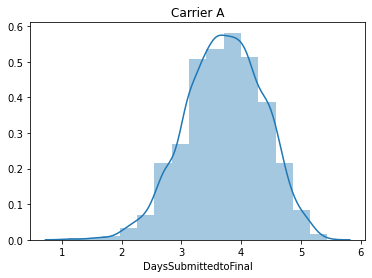

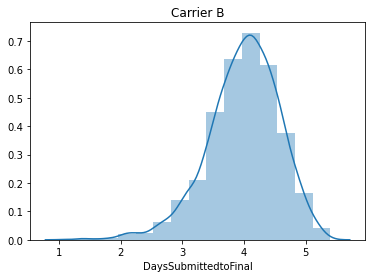

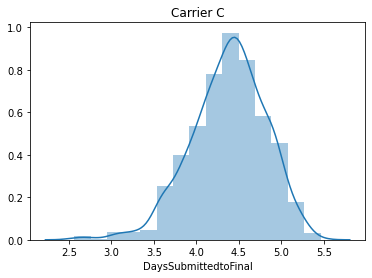

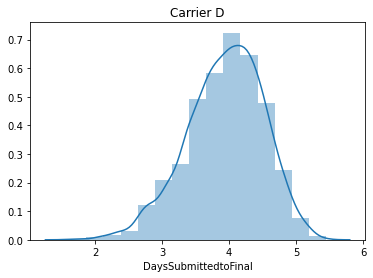

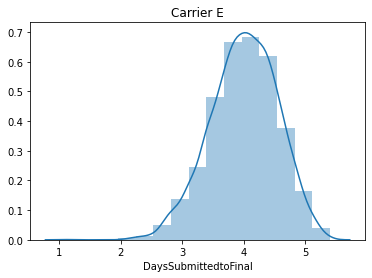

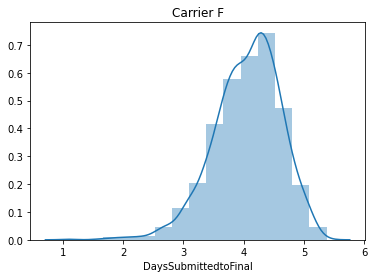

In [27]:
#view the distribution of our target variable for each carrier. We see some skewness and need to remove
#outliers

data_labels = ['Carrier A', 'Carrier B', 'Carrier C', 'Carrier D', 'Carrier E', 'Carrier F']

import seaborn as sns
for i in range(len(data_list)):
    plt.title(data_labels[i])
    sns.distplot(data_list[i][target], bins=15)
    plt.show()

In [28]:
#Returns index values of outliers in our transformed dataset and removes them
for i in range(len(data_list)):
    outliers = data_list[i][(data_list[i][target] > data_list[i][target].mean() + 3*(data_list[i][target].std())) | (data_list[i][target] < data_list[i][target].mean() - 3*(data_list[i][target].std()))].index
    data_list[i].drop(outliers, inplace=True)

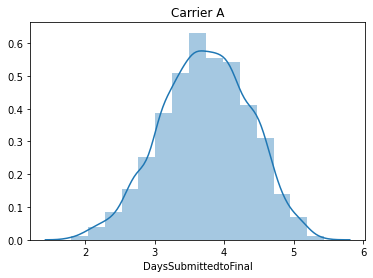

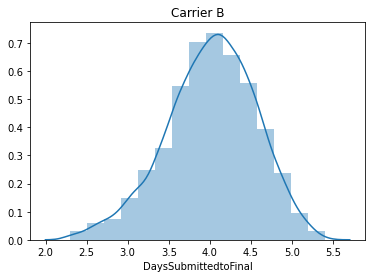

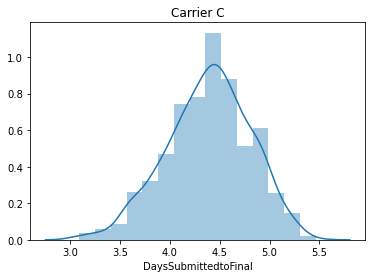

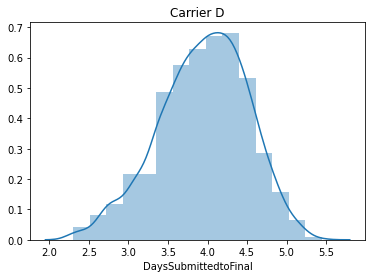

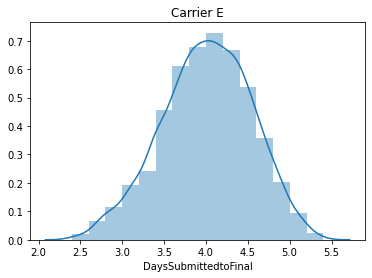

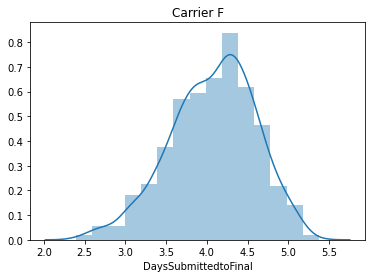

In [29]:
#check to see if the datasets are more normally distributed for our target variable

for i in range(len(data_list)):
    plt.title(data_labels[i])
    sns.distplot(data_list[i][target], bins=15)
    plt.show()

In [30]:
#Making sure that we have removed the whitespace in column names and
#we don't have multiple column names for dummy value columns with only 2
#values
for i in df.columns:
    print(i)

Policy#
Benefit
DaysinSubmitted
DaysinUnderwriting
DaysinApproval
DaysinIssued
DaysSubmittedtoFinal
InsuredAge
#ofAPS?
Carrier_CompanyB
Carrier_CompanyC
Carrier_CompanyD
Carrier_CompanyE
Carrier_CompanyF
PlanType_Hybrid
PlanType_SUL
PlanType_SVUL
PlanType_Term
PlanType_UL
PlanType_VUL
PlanTypeGroup_Perm
PlanTypeGroup_Term
RiskClass_PreferredNon-Smoker
RiskClass_PreferredPlus
RiskClass_PreferredSmoker
RiskClass_Rated/SubstandardRisk
RiskClass_StandardNon-Smoker
RiskClass_StandardPlus
RiskClass_StandardSmoker
Interview_Yes
Exam_Yes
1035?_Yes
U/WCombined
new_cases
new_cases_smoothed
new_deaths
new_deaths_smoothed
new_cases_per_million
new_cases_smoothed_per_million
new_deaths_per_million
new_deaths_smoothed_per_million
stringency_index


In [31]:
#This code runs the df_clean function on all our datasets which will remove features that unfairly explain
#the target variable. For example, when predicting days submitted to final, having days in submitted, days in underwriting,
#etc. You can sum these up to get an accurate prediction. When receiving a new application you do not know how
#long it is going to take in each stage and therefore we needed to remove these features.

for i in range(len(data_list)):
    data_list[i] = df_clean(data_list[i], target)

#Also need to clean our original dataframe for use in our model for all companies    
df = df_clean(df, target)


In [32]:
#Checking for multi-colinearity by creating a dictionary that saves features used in our model and checks to see what is
#correlated with it from the other set of features. From here we will decide what features to keep in our model

#Need to add a list to loop through all of our different dataframes 
#we use df for an overall model and data_list for the individual carrier models
df_list = [df, data_list[0], data_list[1], data_list[2], data_list[3], data_list[4], data_list[5]]

#In order to calculate SLA's we needed to keep these features in our model. The plan types are highly 
#correlated with one another although they are not correlated with the other features. 
#Exams and U/W are highly correlated, but we need to keep them in order to understand the SLAs
kept_feats = ['PlanType_Term', 'PlanTypeGroup_Perm', 'Exam_Yes', 'U/WCombined', 'PlanType_VUL']

for q in range(len(df_list)):
    multi_co = dict()
    val_lst = list()
    col_list = list(df_list[q].columns)

    for i in range(len(col_list)):
        val_lst.clear()
        x = pd.DataFrame(df_list[q].corrwith(df_list[q][col_list[i]]))
        y = x[(abs(x[0]) > .8)]
        if len(y) == 0:
            continue
        else:
            for a in y.index:
                if ((a == col_list[i]) | (a in kept_feats)):
                    continue
                else:
                    val_lst.append(a)
            if val_lst: 
                multi_co[col_list[i]] = val_lst
        val_lst = val_lst.copy()
    #Now that we have a dictionary built with features correlated with one another, we will return which values
    #we want to keep from this list. keep_val returns the features to keep in the df from the list of features
    #with multicollinearity.

    val = list(multi_co.keys())
    corr_dat = dict()
    x = df_list[q].corrwith(df_list[q][target])
    keep_val = list()

    for i in val:
        corr_dat[i] = x[i]
        for a in multi_co[i]:
            corr_dat[a] = x[a]
        maxkey = max(corr_dat, key=lambda y: abs(corr_dat[y]))
        if maxkey not in keep_val:
            keep_val.append(maxkey)
        corr_dat.clear()

    #we are going to drop values that are not in our keep val list. This loop searches through
    #our dictionary keys and adds the key name to drop_col if it is not one of the features we wish to keep
    drop_col = list()

    for i in val:
        if i in keep_val:
            continue
        else:
            drop_col.append(i)

    df_list[q].drop(drop_col, axis=1, inplace=True)
    multi_co.clear()
    val_lst.clear()
    col_list.clear()
    val.clear()
    corr_dat.clear()
    keep_val.clear()
    drop_col.clear()

In [33]:
#We wanted to be able to view the correlation between each feature
#in all dataframes to be able to understand what is impacting our 
#cycle time
names = ['Overall Dataframe', 'Carrier A', 'Carrier B', 
        'Carrier C', 'Carrier D', 'Carrier E', 'Carrier F']

for i in range(len(df_list)):
    print(names[i])
    print()
    corr = df_list[i].corrwith(df_list[i][target])
    corr.drop(target, inplace=True)
    print(corr.sort_values(ascending=False))
    print()

Overall Dataframe

#ofAPS?                            0.387855
Exam_Yes                           0.364884
U/WCombined                        0.323155
1035?_Yes                          0.250686
PlanTypeGroup_Perm                 0.221523
PlanType_VUL                       0.176651
RiskClass_StandardNon-Smoker       0.149478
InsuredAge                         0.149190
RiskClass_Rated/SubstandardRisk    0.107702
PlanType_UL                        0.036720
RiskClass_StandardSmoker           0.035825
PlanType_SVUL                      0.035640
RiskClass_PreferredSmoker          0.027400
PlanType_SUL                       0.020279
Benefit                            0.010790
RiskClass_StandardPlus             0.010556
Interview_Yes                     -0.056899
RiskClass_PreferredNon-Smoker     -0.081792
PlanType_Term                     -0.108133
RiskClass_PreferredPlus           -0.130706
new_deaths_smoothed               -0.132601
stringency_index                  -0.200231
PlanType_Hybr

In [34]:
#We remove interview yes from Company D's dataframe due to incomplete data

if 'Interview_Yes' in data_list[3].columns:
    data_list[3].drop(['Interview_Yes'], axis=1, inplace=True)

# Building and Evaluating Models

## Model for all companies

In [35]:
#Testing Linear regression model without a constant for all of the data
#at once instead of segmenting by carrier

#log transform target variable
from scipy.stats import skew
df = df.copy()
df[target] = np.log1p(df[target])

#log transform numeric features that are skewed
numeric_feats = df.dtypes[(df.dtypes != "object") & (df.dtypes != 'datetime64[ns]')].index
skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
df[skewed_feats] = np.log1p(df[skewed_feats])

#remove outliers
outliers = df[(df[target] > df[target].mean() + 3*(df[target].std())) | (df[target] < df[target].mean() - 3*(df[target].std()))].index
df.drop(outliers, inplace=True)

from sklearn.model_selection import train_test_split
x = df.drop(target, axis=1)
y = df[target]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.3, random_state=101)

from sklearn.linear_model import LinearRegression
li = LinearRegression(fit_intercept=True)
li.fit(x_train, y_train)
y_pred = li.predict(x_test)

scores = cross_validate(li, x_train, y_train, cv=5, return_estimator=True)
result = scores['test_score'].mean()
print(result)

0.3619780566044348


In [36]:
#We wanted to see what features had the highest coefficients to understand
#what had the largest impact on our target variable

co = pd.DataFrame(li.coef_, index=x_train.columns, columns=['Coefficient'])
co.at['Intercept'] = li.intercept_

co.sort_values(by='Coefficient', ascending=False)

,Coefficient
Intercept,3.973838
1035?_Yes,0.499038
#ofAPS?,0.333778
U/WCombined,0.231222
Exam_Yes,0.185515
Interview_Yes,0.068304
stringency_index,0.010518
Benefit,0.000742
InsuredAge,-0.000616
RiskClass_StandardPlus,-0.006724


In [37]:
from sklearn.metrics import r2_score
print('R^2 Score:', r2_score(y_test, y_pred))

R^2 Score: 0.3660759464510639


## Optimized Model for each Carrier

In [38]:
results = {}
key_val = ['Carrier A', 'Carrier B', 'Carrier C', 'Carrier D',
              'Carrier E', 'Carrier F']
index_val = {}

for i in range(len(data_list)):
    x = data_list[i].drop(target, axis=1)
    y = data_list[i][target]
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.2, random_state=101)
    from sklearn.model_selection import GridSearchCV
    index_val[key_val[i]] = y_test.index

    #create a feature named start_time which is the current time in seconds
    #we use this to calculate how long it takes to run lines of code below
    start_time = time.time()
    print(key_val[i])
    #Linear Regression
    from sklearn.linear_model import LinearRegression
    li = LinearRegression()
    param_gridLin = {'normalize': [True, False],
                  'copy_X': [True, False]}
    gsLin = GridSearchCV(li, param_gridLin, cv=10)
    gsLin.fit(x_train, y_train)
    y_Lin = gsLin.predict(x_test)

    #Returns how many minutes it takes to run the linear regression code
    print('Time to Run Linear:', (time.time() - start_time)/60)

    #DecisionTree Regressor
    from sklearn.tree import DecisionTreeRegressor
    dtreg = DecisionTreeRegressor()
    param_gridDT = {'splitter': ('best', 'random'),
                 'max_depth': (None, 20, 40, 60),
                 'max_features': ('auto', 'sqrt', 'log2', None)}
    gsDT = GridSearchCV(dtreg, param_gridDT, cv=10)
    gsDT.fit(x_train, y_train)
    y_dt = gsDT.predict(x_test)
    print('Time to Run Decision Tree:', (time.time() - start_time)/60)

    #XGBoost Model
    import xgboost as xgb
    dtrain = xgb.DMatrix(x_train, label=y)
    dtest = xgb.DMatrix(x_test)
    params = {'max_depth':2, 'eta':0.1}
    model= xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)
    model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=.1)
    model_xgb.fit(x_train, y_train)
    xgb_pred = np.expm1(model_xgb.predict(x_test))
    print('Time to Run XGBoost Regression:', (time.time() - start_time)/60)

    from sklearn.ensemble import RandomForestRegressor
    rfr = RandomForestRegressor()
    rfr.fit(x_train, y_train)
    rfr_pred = rfr.predict(x_test)
    print('Time to Run Random Forest:', (time.time() - start_time)/60)

    #Nearest Neighbors Regression
    from sklearn.neighbors import KNeighborsRegressor
    knr = KNeighborsRegressor()
    param_gridkn = {'n_neighbors': (3,5,7),
                   'algorithm': ('auto', 'ball_tree', 'kd_tree')}
    gsKN = GridSearchCV(knr, param_gridkn, cv=10)
    gsKN.fit(x_train, y_train)
    y_KN = gsKN.predict(x_test)
    print('Time to Run Nearest Neighbors:', (time.time() - start_time)/60)

    #Evaluate all models and returns average test score for each model in a dictionary labeled model_eval
    model_eval = dict()
    model_names = [gsLin, gsDT, model_xgb, rfr, gsKN]
    model_titles = ['Linear Regression', 'Decision Tree', 'XGBoost', 'Random Forest', 'Nearest Neighbors']

    for index, q in enumerate(model_names):
        scores = cross_validate(q, x_train, y_train, cv=5, return_estimator=True)
        a = scores['test_score'].mean()
        model_eval[model_titles[index]] = a
    print(model_eval)
    
    #This portion of the code finds the best performing model for each Carrier and saves a dataframe with those predictions
    #along with the actual test values to a dataframe. This is all saved into a dictionary labeled results
    c=i
    import operator
    item = max(model_eval.items(), key=operator.itemgetter(1))[0]
    if item == 'Linear Regression':
        pred_df = pd.DataFrame(data={'Predictions': np.expm1(y_Lin), 'Actual': np.expm1(y_test)}, index=y_test.index)
        combined = pd.concat([x_test, pred_df], axis=1)
        results.update({key_val[c]: combined})
        print('Linear Regression is best for', key_val[i])
    elif item == 'Decision Tree':
        pred_df = pd.DataFrame(data={'Predictions': np.expm1(y_dt), 'Actual': np.expm1(y_test)}, index=y_test.index)
        combined = pd.concat([x_test, pred_df], axis=1)
        results.update({key_val[c]: combined})
        print('Decision Tree is best for', key_val[i])
    elif item == 'XGBoost':
        pred_df = pd.DataFrame(data={'Predictions': xgb_pred, 'Actual': np.expm1(y_test)}, index=y_test.index)
        combined = pd.concat([x_test, pred_df], axis=1)
        results.update({key_val[c]: combined})
        print('XGBoost is best for', key_val[i])
    elif item == 'Nearest Neighbors':
        pred_df = pd.DataFrame(data={'Predictions': np.expm1(y_KN), 'Actual': np.expm1(y_test)}, index=y_test.index)
        combined = pd.concat([x_test, pred_df], axis=1)
        results.update({key_val[c]: combined})
        print('Nearest Neighbors is best for', key_val[i])
    else:
        pred_df = pd.DataFrame(data={'Predictions': np.expm1(rfr_pred), 'Actual': np.expm1(y_test)}, index=y_test.index)
        combined = pd.concat([x_test, pred_df], axis=1)
        results.update({key_val[c]: combined})
        print('Random Forest is best for', key_val[i])
        
    print()


Carrier A
Time to Run Linear: 0.005106155077616374
Time to Run Decision Tree: 0.08285790681838989


C:\Users\jlucz\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Time to Run XGBoost Regression: 0.17105831702550253
Time to Run Random Forest: 0.18941831986109417
Time to Run Nearest Neighbors: 0.22473385334014892
{'Linear Regression': 0.425514630810946, 'Decision Tree': 0.04943952290563527, 'XGBoost': 0.43821906711626735, 'Random Forest': 0.37842605722203704, 'Nearest Neighbors': 0.2907593677715449}
XGBoost is best for Carrier A

Carrier B
Time to Run Linear: 0.00430516004562378
Time to Run Decision Tree: 0.06766017278035481
Time to Run XGBoost Regression: 0.07659473021825154
Time to Run Random Forest: 0.09415725469589234
Time to Run Nearest Neighbors: 0.12852417627970378
{'Linear Regression': 0.3394214215717672, 'Decision Tree': -0.051227268460870154, 'XGBoost': 0.3649190721250653, 'Random Forest': 0.26747788670364797, 'Nearest Neighbors': 0.2418185227754981}
XGBoost is best for Carrier B

Carrier C
Time to Run Linear: 0.0038150469462076824
Time to Run Decision Tree: 0.038825627168019614
Time to Run XGBoost Regression: 0.04269860982894898
Time to

In [39]:
#Our predictions did not perform very well. We may need to look at more methods to be able to better explain the 
#variability in our data. We have exhausted as many options as we could think of

from sklearn.metrics import r2_score
for i in range(len(key_val)):
    print(key_val[i], 'R^2 Score: ', r2_score(results[key_val[i]]['Actual'], results[key_val[i]]['Predictions']))

Carrier A R^2 Score:  0.4266743528283382
Carrier B R^2 Score:  0.2671824479457643
Carrier C R^2 Score:  0.3126347030114255
Carrier D R^2 Score:  0.18744454817468137
Carrier E R^2 Score:  0.30196693523146934
Carrier F R^2 Score:  0.3963201346050991


# Evaluating SLA

Now that we have our models complete for each individual carrier we want to know what is the average cycle time for the entire lifecycle of a claim before evaluating how each element of a claim affects the time. 

In [40]:
#we took an exhaustive approach to try and come up with an ideal SLA time by using models for each individual carrier.
#This allows us to analyze the nuances of each carrier individually and use the averages to get an agreed upon SLA.
#By using weights for each average we are able to account for how many cases are from each carrier while also being able 
#to understand what factors effect each carrier

sla = 0
for i in range(len(key_val)):
    sla += weights[key_val[i]]*(results[key_val[i]]['Predictions'].mean())
    
sla

54.947444515676004

Since we used non linear models for most of the carriers, we had to take a different approach to view how many days each element of the SLA added to the overall process time. As seen below we wanted to view how many days an APS typically adds to the lifecycle of the claim. To do this, we needed to grab the average time with and without an APS for each carrier and multiple them by specific weights. 

### The effect of APS on Cycle Time

In [41]:
#How does having an APS affect cycle time?

#First we need to determine the weights used to calculate the average cycle time with and without an APS
#to do this we looped through each carriers resulting test set and found the length of that dataframe. 
#This is then used to determine calculate weights
if target != 'DaysinSubmitted':
    total_len = 0
    total_len2 = 0
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            total_len += len(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] > 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0) & (results[key_val[i]]['1035?_Yes'] == 0)])
            total_len2 += len(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0) & (results[key_val[i]]['1035?_Yes'] == 0)])
        
        else:
            total_len += len(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] > 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['1035?_Yes'] == 0)])
            total_len2 += len(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['1035?_Yes'] == 0)])

    #Loop to calculate the weights that we multiple by the average time for each carrier
    aps_weights = {}
    noaps_weights = {}
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            aps_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] > 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0) & (results[key_val[i]]['1035?_Yes'] == 0)])/total_len
            noaps_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0) & (results[key_val[i]]['1035?_Yes'] == 0)])/total_len2
        else:
            aps_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] > 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['1035?_Yes'] == 0)])/total_len
            noaps_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['1035?_Yes'] == 0)])/total_len2

    #Grab the sumproduct of each companies assigned weight times their average predicted time with and without an APS
    aps = 0
    no_aps = 0
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            aps += aps_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] > 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0) & (results[key_val[i]]['1035?_Yes'] == 0)]['Predictions'].mean())
            no_aps += noaps_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0) & (results[key_val[i]]['1035?_Yes'] == 0)]['Predictions'].mean())
        else:
            aps += aps_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] > 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['1035?_Yes'] == 0)]['Predictions'].mean())
            no_aps += noaps_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['1035?_Yes'] == 0)]['Predictions'].mean())
    print('Predicted:')
    print('Average CT with APS:', aps)
    print('Average CT without APS:', no_aps)
    print('Difference:', aps-no_aps)
    print()
if target != 'DaysinSubmitted':
    total_len = 0
    total_len2 = 0
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            total_len += len(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] > 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0) & (results[key_val[i]]['1035?_Yes'] == 0)])
            total_len2 += len(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0) & (results[key_val[i]]['1035?_Yes'] == 0)])
        
        else:
            total_len += len(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] > 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['1035?_Yes'] == 0)])
            total_len2 += len(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['1035?_Yes'] == 0)])

    #Loop to calculate the weights that we multiple by the average time for each carrier
    aps_weights = {}
    noaps_weights = {}
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            aps_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] > 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0) & (results[key_val[i]]['1035?_Yes'] == 0)])/total_len
            noaps_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0) & (results[key_val[i]]['1035?_Yes'] == 0)])/total_len2
        else:
            aps_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] > 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['1035?_Yes'] == 0)])/total_len
            noaps_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['1035?_Yes'] == 0)])/total_len2

    #Grab the sumproduct of each companies assigned weight times their average predicted time with and without an APS
    aps = 0
    no_aps = 0
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            aps += aps_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] > 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0) & (results[key_val[i]]['1035?_Yes'] == 0)]['Actual'].mean())
            no_aps += noaps_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0) & (results[key_val[i]]['1035?_Yes'] == 0)]['Actual'].mean())
        else:
            aps += aps_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] > 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['1035?_Yes'] == 0)]['Actual'].mean())
            no_aps += noaps_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['1035?_Yes'] == 0)]['Actual'].mean())
    print('Actual:')
    print('Average CT with APS:', aps)
    print('Average CT without APS:', no_aps)
    print('Difference:', aps-no_aps)

Predicted:
Average CT with APS: 72.78336481181924
Average CT without APS: 53.43283136422035
Difference: 19.35053344759889

Actual:
Average CT with APS: 79.15868263473055
Average CT without APS: 58.94075829383887
Difference: 20.217924340891685


Next we wanted to see how Perm and Hybrid products were affected by a 1035 exchange. We needed to exclude APS to view the effect of a 1035 solely on cycle time.

### The effect of a 1035 on Cycle Time

In [42]:
#How does having a 1035 affect cycle time?

#First we need to determine the weights used to calculate the average cycle time with and without a 1035
#to do this we looped through each carriers resulting test set and found the length of that dataframe. 
#This is then used to determine calculate weights
if target != 'DaysinSubmitted':
    total_len = 0
    total_len2 = 0
    for i in range(len(key_val)):
        total_len += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] > 0) & (results[key_val[i]]['PlanType_Term'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0)])
        total_len2 += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['PlanType_Term'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0)])

    total_len

    #Loop to calculate the weights that we multiple by the average time for each carrier
    exchange_weights = {}
    noexchange_weights = {}
    for i in range(len(key_val)):
        exchange_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] > 0) & (results[key_val[i]]['PlanType_Term'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0)])/total_len
        noexchange_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['PlanType_Term'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0)])/total_len2

    #Grab the sumproduct of each companies assigned weight times their average predicted time with and without a 1035
    exchange = 0
    no_exchange = 0
    for i in range(len(key_val)):
        exchange += exchange_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] > 0) & (results[key_val[i]]['PlanType_Term'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0)]['Predictions'].mean())
        no_exchange += noexchange_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['PlanType_Term'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0)]['Predictions'].mean())
    print('Predicted:')
    print('Average CT with 1035:', exchange)
    print('Average CT without 1035:', no_exchange)
    print('Difference:', exchange-no_exchange)
    print()
if target != 'DaysinSubmitted':
    total_len = 0
    total_len2 = 0
    for i in range(len(key_val)):
        total_len += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] > 0) & (results[key_val[i]]['PlanType_Term'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0)])
        total_len2 += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['PlanType_Term'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0)])

    total_len

    #Loop to calculate the weights that we multiple by the average time for each carrier
    exchange_weights = {}
    noexchange_weights = {}
    for i in range(len(key_val)):
        exchange_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] > 0) & (results[key_val[i]]['PlanType_Term'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0)])/total_len
        noexchange_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['PlanType_Term'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0)])/total_len2

    #Grab the sumproduct of each companies assigned weight times their average predicted time with and without a 1035
    exchange = 0
    no_exchange = 0
    for i in range(len(key_val)):
        exchange += exchange_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] > 0) & (results[key_val[i]]['PlanType_Term'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0)]['Actual'].mean())
        no_exchange += noexchange_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['PlanType_Term'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0)]['Actual'].mean())
    print('Actual:')
    print('Average CT with 1035:', exchange)
    print('Average CT without 1035:', no_exchange)
    print('Difference:', exchange-no_exchange)

Predicted:
Average CT with 1035: 70.95991768423966
Average CT without 1035: 45.14186351879223
Difference: 25.81805416544743

Actual:
Average CT with 1035: 76.49999999999999
Average CT without 1035: 48.71351351351352
Difference: 27.786486486486467


### The effect of Full or Reduced Underwriting on Cycle Time

In [43]:
#First we need to determine the weights used to calculate the average cycle time with and without a 1035
#to do this we looped through each carriers resulting test set and found the length of that dataframe. 
#This is then used to determine calculate weights
if target != 'DaysinSubmitted':
    total_len = 0
    total_len2 = 0
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            total_len += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0)])
            total_len2 += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 0) & (results[key_val[i]]['PlanType_Hybrid'] == 0)])
        
        else:
            total_len += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1)])
            total_len2 += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 0)])

    total_len

    #Loop to calculate the weights that we multiple by the average time for each carrier
    uw_weights = {}
    express_weights = {}
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            uw_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0)])/total_len
            express_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 0) & (results[key_val[i]]['PlanType_Hybrid'] == 0)])/total_len2
        else:
            uw_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1)])/total_len
            express_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 0)])/total_len2
    #Grab the sumproduct of each companies assigned weight times their average predicted time with and without a 1035
    full = 0
    express = 0
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            full += uw_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0)]['Predictions'].mean())
            express += express_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 0) & (results[key_val[i]]['PlanType_Hybrid'] == 0)]['Predictions'].mean())
        else:
            full += uw_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1)]['Predictions'].mean())
            express += express_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 0)]['Predictions'].mean())
    print('Predicted:')
    print('Average CT with full underwriting:', full)
    print('Average CT with express underwriting:', express)
    print('Difference:', full-express)
    print()
if target != 'DaysinSubmitted':
    total_len = 0
    total_len2 = 0
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            total_len += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0)])
            total_len2 += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 0) & (results[key_val[i]]['PlanType_Hybrid'] == 0)])
        
        else:
            total_len += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1)])
            total_len2 += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 0)])

    total_len

    #Loop to calculate the weights that we multiple by the average time for each carrier
    uw_weights = {}
    express_weights = {}
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            uw_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0)])/total_len
            express_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 0) & (results[key_val[i]]['PlanType_Hybrid'] == 0)])/total_len2
        else:
            uw_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1)])/total_len
            express_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 0)])/total_len2
    #Grab the sumproduct of each companies assigned weight times their average predicted time with and without a 1035
    full = 0
    express = 0
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            full += uw_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0)]['Actual'].mean())
            express += express_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 0) & (results[key_val[i]]['PlanType_Hybrid'] == 0)]['Actual'].mean())
        else:
            full += uw_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1)]['Actual'].mean())
            express += express_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 0)]['Actual'].mean())
    print('Actual:')
    print('Average CT with full underwriting:', full)
    print('Average CT with express underwriting:', express)
    print('Difference:', full-express)

Predicted:
Average CT with full underwriting: 53.43283136422035
Average CT with express underwriting: 33.89771840072863
Difference: 19.53511296349172

Actual:
Average CT with full underwriting: 58.94075829383887
Average CT with express underwriting: 38.27213822894168
Difference: 20.66862006489719


### The effect of Exam on Cycle Time

In [44]:
#First we need to determine the weights used to calculate the average cycle time with and without an exam
#to do this we looped through each carriers resulting test set and found the length of that dataframe. 
#This is then used to determine calculate weights
skip_val = ['DaysinApproval', 'DaysinIssued', 'DaysinSubmitted']

if target not in skip_val:
    total_len = 0
    total_len2 = 0
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            total_len += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0)])
            total_len2 += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['PlanType_Hybrid'] == 0)])
       
        else:
            total_len += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 1)])
            total_len2 += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 0)])

    total_len

    #Loop to calculate the weights that we multiple by the average time for each carrier
    exam_weights = {}
    noexam_weights = {}
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            exam_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0)])/total_len
            noexam_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['PlanType_Hybrid'] == 0)])/total_len2
        
        else:
            exam_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 1)])/total_len
            noexam_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 0)])/total_len2

    #Grab the sumproduct of each companies assigned weight times their average predicted time with and without an exam
    exam = 0
    no_exam = 0
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            if results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 1)]['Predictions'].mean() is not np.nan:
                exam += exam_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0)]['Predictions'].mean())
            if results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 0)]['Predictions'].mean() is not np.nan:
                no_exam += noexam_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['PlanType_Hybrid'] == 0)]['Predictions'].mean())
        else:
            if results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 1)]['Predictions'].mean() is not np.nan:
                exam += exam_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 1)]['Predictions'].mean())
            if results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 0)]['Predictions'].mean() is not np.nan:
                no_exam += noexam_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 0)]['Predictions'].mean())
    print('Predicted:')
    print('Average CT with exam:', exam)
    print('Average CT without exam:', no_exam)
    print('Difference:', exam-no_exam)
    print()
if target not in skip_val:
    total_len = 0
    total_len2 = 0
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            total_len += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0)])
            total_len2 += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['PlanType_Hybrid'] == 0)])
       
        else:
            total_len += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 1)])
            total_len2 += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 0)])

    total_len

    #Loop to calculate the weights that we multiple by the average time for each carrier
    exam_weights = {}
    noexam_weights = {}
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            exam_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0)])/total_len
            noexam_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['PlanType_Hybrid'] == 0)])/total_len2
        
        else:
            exam_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 1)])/total_len
            noexam_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 0)])/total_len2

    #Grab the sumproduct of each companies assigned weight times their average predicted time with and without an exam
    exam = 0
    no_exam = 0
    for i in range(len(key_val)):
        if 'PlanType_Hybrid' in results[key_val[i]].columns:
            if results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 1)]['Predictions'].mean() is not np.nan:
                exam += exam_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 1) & (results[key_val[i]]['PlanType_Hybrid'] == 0)]['Actual'].mean())
            if results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 0)]['Predictions'].mean() is not np.nan:
                no_exam += noexam_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['PlanType_Hybrid'] == 0)]['Actual'].mean())
        else:
            if results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 1)]['Predictions'].mean() is not np.nan:
                exam += exam_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 1)]['Actual'].mean())
            if results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 0)]['Predictions'].mean() is not np.nan:
                no_exam += noexam_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['U/WCombined'] == 1) & (results[key_val[i]]['Exam_Yes'] == 0)]['Actual'].mean())
    print('Actual:')
    print('Average CT with exam:', exam)
    print('Average CT without exam:', no_exam)
    print('Difference:', exam-no_exam)

Predicted:
Average CT with exam: 54.43170040890988
Average CT without exam: 49.50062950797703
Difference: 4.931070900932852

Actual:
Average CT with exam: 60.45332211942809
Average CT without exam: 55.119565217391305
Difference: 5.333756902036782


### The effect of Interviews on Cycle Time

In [45]:
#First we need to determine the weights used to calculate the average cycle time with and without an interivew
#to do this we looped through each carriers resulting test set and found the length of that dataframe. 
#This is then used to determine calculate weights

#Company D was removed due to missing data in the interview column
if target not in skip_val:
    total_len = 0
    total_len2 = 0
    for i in range(len(key_val)):
        if i == 3:
            continue
        else:
            total_len += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['Interview_Yes'] == 1)])
            total_len2 += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['Interview_Yes'] == 0)])
    
    total_len

    #Loop to calculate the weights that we multiple by the average time for each carrier
    interview_weights = {}
    nointerview_weights = {}
    for i in range(len(key_val)):
        if i == 3:
            continue
        else:
            interview_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['Interview_Yes'] == 1)])/total_len
            nointerview_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['Interview_Yes'] == 0)])/total_len2

    #Grab the sumproduct of each companies assigned weight times their average predicted time with and without an interview
    interview = 0
    no_interview = 0
    for i in range(len(key_val)):
        if i == 3:
            continue
        else:
            if results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['Interview_Yes'] == 1)]['Predictions'].mean() is not np.nan:
                interview += interview_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['Interview_Yes'] == 1)]['Predictions'].mean())
                no_interview += nointerview_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['Interview_Yes'] == 0)]['Predictions'].mean())
    print('Predicted:')
    print('Average CT with an interview:', interview)
    print('Average CT without an interview', no_interview)
    print('Difference:', interview-no_interview)
    print()
if target not in skip_val:
    total_len = 0
    total_len2 = 0
    for i in range(len(key_val)):
        if i == 3:
            continue
        else:
            total_len += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['Interview_Yes'] == 1)])
            total_len2 += len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['Interview_Yes'] == 0)])
    
    total_len

    #Loop to calculate the weights that we multiple by the average time for each carrier
    interview_weights = {}
    nointerview_weights = {}
    for i in range(len(key_val)):
        if i == 3:
            continue
        else:
            interview_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['Interview_Yes'] == 1)])/total_len
            nointerview_weights[key_val[i]] = len(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['Interview_Yes'] == 0)])/total_len2

    #Grab the sumproduct of each companies assigned weight times their average predicted time with and without an interview
    interview = 0
    no_interview = 0
    for i in range(len(key_val)):
        if i == 3:
            continue
        else:
            if results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['Interview_Yes'] == 1)]['Actual'].mean() is not np.nan:
                interview += interview_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['Interview_Yes'] == 1)]['Actual'].mean())
                no_interview += nointerview_weights[key_val[i]]*(results[key_val[i]][(results[key_val[i]]['1035?_Yes'] == 0) & (results[key_val[i]]['#ofAPS?'] == 0) & (results[key_val[i]]['Exam_Yes'] == 0) & (results[key_val[i]]['Interview_Yes'] == 0)]['Actual'].mean())
    print('Actual:')
    print('Average CT with an interview:', interview)
    print('Average CT without an interview', no_interview)
    print('Difference:', interview-no_interview)

Predicted:
Average CT with an interview: 35.76998774421136
Average CT without an interview 33.298262638832206
Difference: 2.471725105379157

Actual:
Average CT with an interview: 39.94122516556291
Average CT without an interview 34.35820895522388
Difference: 5.583016210339032
